In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *


/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Get Data 
---

In [2]:
prices = pd.read_csv("data/prices_data.csv", index_col=0, parse_dates=True)


In [3]:
prices

,BTC/USDT,ETH/USDT,XRP/USDT,LTC/USDT,BCH/USDT
timestamp,,,,,
2024-02-23,50744.15,2922.24,0.5342,68.80,264.7
2024-02-24,51568.22,2992.62,0.5450,70.41,267.7
2024-02-25,51728.85,3112.59,0.5425,70.16,267.9
2024-02-26,54476.47,3175.94,0.5506,71.93,274.7
2024-02-27,57037.34,3242.36,0.5861,73.97,292.8
...,...,...,...,...,...
2025-02-17,95780.00,2744.05,2.6599,122.31,323.8
2025-02-18,95671.74,2671.99,2.5628,129.75,316.3
2025-02-19,96644.37,2715.50,2.7378,134.88,322.8


# Applly funnel and test for cointegration
---

In [4]:

# Pre-filter: Calculate correlation matrix and select pairs with high correlation
corr_threshold = 0.8
corr_matrix, high_corr_pairs = filter_high_correlation_pairs(prices, threshold=corr_threshold)
print(f"\nPairs with correlation >= {corr_threshold}:")
for pair in high_corr_pairs:
    print(f"{pair[0]} & {pair[1]}: correlation = {pair[2]:.4f}")

# Cointegration test
cointegrated_pairs, pvalue_matrix, residuals_df = find_cointegrated_pairs(prices, high_corr_pairs,significance=0.05)



Pairs with correlation >= 0.8:
BTC/USDT & XRP/USDT: correlation = 0.9238
BTC/USDT & LTC/USDT: correlation = 0.8630
XRP/USDT & LTC/USDT: correlation = 0.8555

Cointegrated pairs (from pre-filtered high-correlation pairs):
BTC/USDT & XRP/USDT: p-value = 0.0333, correlation = 0.9238


In [5]:
analyze_residuals(residuals_df, lags = 20)

P-value for Ljung-Box test for pair BTC/USDT_XRP/USDT: 0.617448397217488
Residuals of pair BTC/USDT_XRP/USDT are likely white noise (independent).


# Test strategy
---


Testing strategy on pair: BTC/USDT and XRP/USDT (p-value: 0.0333, correlation: 0.9238)
Hedge ratio (beta) for BTC/USDT ~ XRP/USDT: 16875.5486


/Users/alex_1/Documents/GitHub/PairsTrading/back_tester.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/Users/alex_1/Documents/GitHub/PairsTrading/back_tester.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


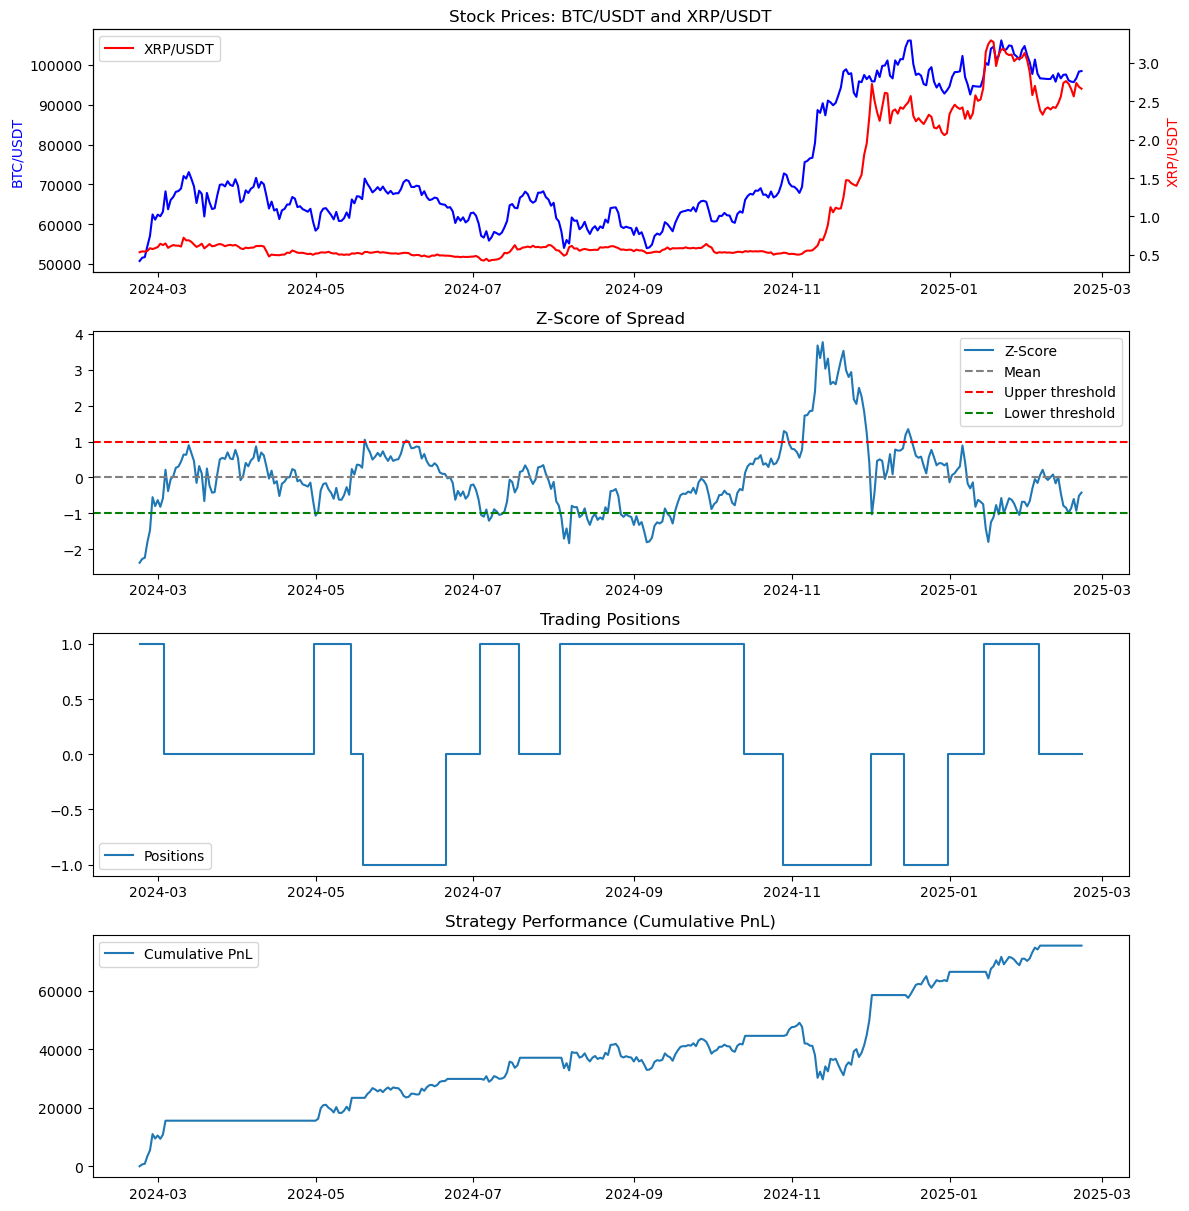

In [19]:
if cointegrated_pairs:
        sym1, sym2, pvalue, corr_val = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (p-value: {pvalue:.4f}, correlation: {corr_val:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
    
        # Compute the spread and hedge ratio
        spread, beta = compute_spread(S1, S2)
        print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
    
        # Generate trading signals based on the spread's z-score
        zscore, positions = backtest_pair(spread, entry_threshold=1.0, exit_threshold=0.0)
    
        # Simulate strategy performance
        pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)
    
        # Visualization
        plt.figure(figsize=(12, 15))
    
        plt.subplot(5, 1, 1)

        #Plot s1 and s2 with separate y-axis

        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax1.plot(S1, label=sym1, color='blue')
        ax2.plot(S2, label=sym2, color='red')
        ax1.set_ylabel(sym1, color='blue')
        ax2.set_ylabel(sym2, color='red')
        plt.title(f"Stock Prices: {sym1} and {sym2}")
        plt.legend()


    
        plt.subplot(5, 1, 2)
        plt.plot(zscore, label='Z-Score')
        plt.axhline(0, color='grey', linestyle='--', label='Mean')
        plt.axhline(1.0, color='red', linestyle='--', label='Upper threshold')
        plt.axhline(-1.0, color='green', linestyle='--', label='Lower threshold')
        plt.title("Z-Score of Spread")
        plt.legend()
        
        
        plt.subplot(5, 1, 3)
        plt.plot(positions, label='Positions', drawstyle='steps-mid')
        plt.title("Trading Positions")
        plt.legend()

        # plt.tight_layout()
        # plt.show()

    
        plt.subplot(5, 1, 4)
        plt.plot(cum_pnl, label='Cumulative PnL')
        plt.title("Strategy Performance (Cumulative PnL)")
        plt.legend()
    
        plt.tight_layout()
        plt.show()